# Social Data Analysis 

In [ ]:
# installazione della libreria transformers
!pip install transformers

In [ ]:
import pandas as pd 
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BritishGP_cleaned_clusters_1000.csv")
df.head()

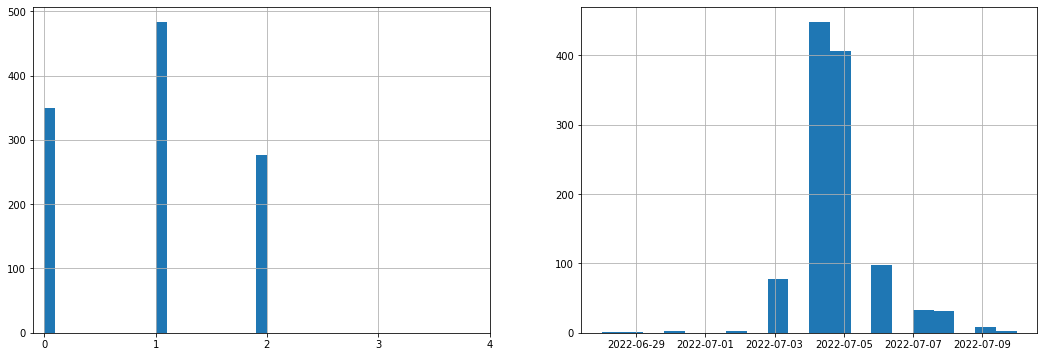

In [5]:
import matplotlib.pyplot as plt


fig,ax = plt.subplots(1,2,figsize=(18,6))
df['clusters'].hist(bins=20,ax=ax[0])

df['date'] = pd.to_datetime(df['date']).dt.date
df['date'].hist(bins=20,ax=ax[1])
p = ax[0].set_xticks(list(range(5)))

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Elbow_methodDistribuzioni_tweet_cluster_date.jpg')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110 entries, 0 to 1109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_name                  1110 non-null   object 
 1   user_location              683 non-null    object 
 2   user_description           954 non-null    object 
 3   user_verified              1110 non-null   bool   
 4   id                         1110 non-null   int64  
 5   date                       1110 non-null   object 
 6   text                       1110 non-null   object 
 7   in_reply_to_status_id      21 non-null     float64
 8   in_reply_to_user_id        25 non-null     float64
 9   retweet_original_user      710 non-null    float64
 10  retweet_original_tweet_id  710 non-null    float64
 11  hashtags                   641 non-null    object 
 12  retweet_count              1110 non-null   int64  
 13  favorite_count             1110 non-null   int64

## Sentiment Analysis per clusters
Per fare la sentiment analysis dei tweet in italiano usiamo il modello **MilaNLProc/feel-it-italian-emotion**

In [7]:
import torch
import numpy as np 
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# sentences è la lista di frasi
def compute_sentiment(sentences,model,tokenizer):
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(model)

    inputs = tokenizer(sentences, return_tensors="pt",padding=True)

    # Call the model and get the logits
    labels = torch.tensor([1]*len(sentences)).unsqueeze(0)  # Batch size 1
    outputs = model(**inputs, labels=labels)
    loss, logits = outputs[:2]
    logits = logits.squeeze(0)

    # Extract probabilities
    proba = torch.nn.functional.softmax(logits, dim=0)
    proba = proba.cpu().detach().numpy()
    sentiment = np.argmax(proba,axis=-1)
    
    string_sentiment = np.array(['Positive']*sentiment.shape[0])
    string_sentiment[sentiment==0] = 'Negative'

    return string_sentiment
#restituisce una lista di stringhe che ha come etichette positivo o negativo per ogni frase in input



# sentences è la lista di frasi
def compute_emotion(sentences,model,tokenizer):
    # Load model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(tokenizer)
    model = AutoModelForSequenceClassification.from_pretrained(model)

    inputs = tokenizer(sentences, return_tensors="pt",padding=True)

    # Call the model and get the logits
    labels = torch.tensor([1]*len(sentences)).unsqueeze(0)  # Batch size 1
    outputs = model(**inputs, labels=labels)
    loss, logits = outputs[:2]
    logits = logits.squeeze(0)

    # Extract probabilities
    proba = torch.nn.functional.softmax(logits, dim=0)
    proba = proba.cpu().detach().numpy()
    emotion = np.argmax(proba,axis=-1)
    
    string_emotion = np.array(['Anger']*emotion.shape[0])
    string_emotion[emotion==1] = 'Fear'
    string_emotion[emotion==2] = 'Joy'
    string_emotion[emotion==3] = 'Sadness'

    return string_emotion
#restituisce una lista di stringhe che ha come etichette le emotions (anger, fear, joy, sadness) per ogni frase in input


In [8]:
#DEFINISCO IL MODEL ED IL TOKENIZER PER LA SENTIMENT ANALYSIS
tokenizer = "MilaNLProc/feel-it-italian-sentiment"
model = "MilaNLProc/feel-it-italian-sentiment"

Siamo interessati alla colonna text del dataframe che vogliamo usare come input per conoscerne il sentiment. Vogliamo pero conoscere il sentiment per ogni cluster quindi definiamo una variabile id_cluster per individuare ciascun cluster

In [9]:
id_cluster = 1

Andiamo a prendere solo i tweet del cluster che vogliamo considerare specificato da id_cluster

In [8]:
# estraggo da tutti i tweet solo quelli appartenenti al cluster di analisi
df_subset = df[df['clusters']==id_cluster]

# estraggo 50 tweet a partire da tutti quelli del cluster [PER VELOCIZZARE L'ESECUZIONE]
# OPERAZIONE DI SAMPLING
df_subset = df_subset[['date','text']].sample(n=100,random_state=0)
#df_subset.head()

# la colonna *text* rappresenta i tweet di cui voglio predirre sentiment ed emozioni
sentences = df_subset['text'].tolist()
#creo questa lista perchè è questa che deve essere data in pasto al modello e quindi alla funzione compute_sentiment

definisco un subset del dataframe contenente solo la data ed i testi dei tweet appartenenti al cluster id_cluster. 
- data: ci da una idea di come è variato nel tempo il sentiment
- testo: ci serve per fare l'analisi

**NB**
Faccio l'operazione **SAMPLING** ovvero di selezione delle 50 frasi random perchè per poter fare un confronto tra i diversi cluster devo avere lo stesso campione statistico. 
Considero nella mia analisi allora un subset di 50 frasi selezionate in maniera casuale.

In [ ]:
df_subset.head()

### sentiment
Possiamo andare ad utilizzare la funzione definita per fare l'analisi del sentiment:

In [10]:
sentiments = compute_sentiment(sentences,model,tokenizer)

In [ ]:
df_subset['sentiment'] = sentiments
df_subset.head()

In [12]:
len(sentiments), len(sentences) # le due liste hanno correttamente la stessa lunghezza

(100, 100)

### Emotional

In [13]:
#DEFINISCO IL MODEL ED IL TOKENIZER PER LA SENTIMENT ANALYSIS - EMOTION
tokenizer = "MilaNLProc/feel-it-italian-emotion"
model = "MilaNLProc/feel-it-italian-emotion"

In [14]:
emotions = compute_emotion(sentences,model,tokenizer)

In [15]:
len(sentences), len(emotions)

(100, 100)

In [ ]:
df_subset["emotion"] = emotions 
df_subset.head()

Abbiamo quindi calcolato il sentiment e la emotions del cluster 1

## Analisi intra-cluster
### Distribuzione all'interno del cluster
Possiamo andare a vedere all'interno di ogni cluster quale è la distribusione dei sentiment o delle emotions

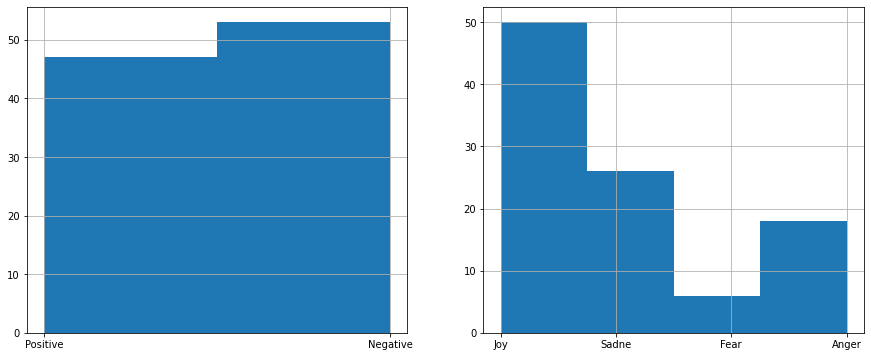

In [17]:
# mostrare il totale dei tweet con sentiment positivo e negativo all'interno del cluster di analisi.
# mostrare il totale dei tweet con emotion (anger, joy, sadness, fear) all'interno del cluster di analisi

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(15,6))

df_subset['sentiment'].hist(bins=2,ax=ax[0])
df_subset['emotion'].hist(bins=4,ax=ax[1])

### Distribuzione del sentiment intra-cluster al variare della data
voglio rappresentare il numero di tweet nel tempo che hanno veicolato un sentiment positivo o negativo oppure una emozione fra le 4 possibili.

In [18]:
df_new = pd.get_dummies(df_subset[['sentiment','emotion']]) #discretizzo il sentiment e l'emotion
df_new['date'] = df_subset['date']
df_new = df_new.groupby('date').sum() #raggruppo per data

df_new.head()

,sentiment_Negative,sentiment_Positive,emotion_Anger,emotion_Fear,emotion_Joy,emotion_Sadne
date,,,,,,
2022-06-29,0,1,0,0,1,0
2022-07-03,8,6,3,1,6,4
2022-07-04,25,21,8,1,23,14
2022-07-05,12,11,5,3,11,4
2022-07-06,6,2,1,1,3,3


In [ ]:
df_subset.head()

In questo passaggio abbiamo trasformato i valori del sentiment e delle emotions in features con valori 1 o 0 a seconda se sono presenti o meno. 
Con la group by vado a contare quanti ce ne sono per ogni data. 

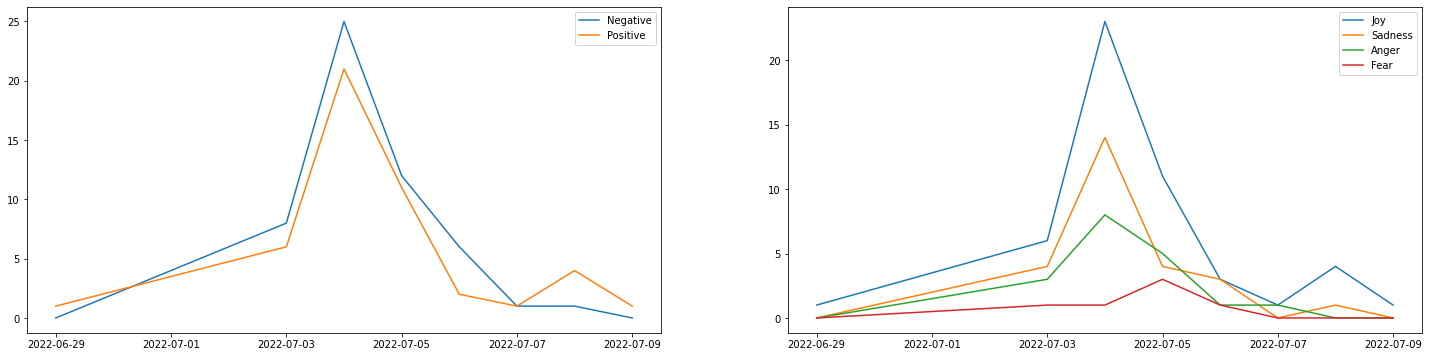

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(25,6))

ax[0].plot(df_new.index,df_new['sentiment_Negative'],label='Negative')
ax[0].plot(df_new.index,df_new['sentiment_Positive'],label="Positive")
ax[0].legend()

ax[1].plot(df_new.index,df_new['emotion_Joy'],label='Joy')
ax[1].plot(df_new.index,df_new['emotion_Sadne'],label="Sadness")
ax[1].plot(df_new.index,df_new['emotion_Anger'],label='Anger')
ax[1].plot(df_new.index,df_new['emotion_Fear'],label="Fear")
ax[1].legend()


In [22]:
df_subset.to_csv("/content/drive/MyDrive/Colab Notebooks/BritishGP_emotion_sentiment_100.csv", index=False)